In [1]:
import os

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) == 3

# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
from dotmap import DotMap

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [2]:
import models
import training
import datasets
import vizualization
import schedules

In [3]:
config = DotMap({
    'distributed': True,
    'minibatch_size': 32,
    'num_devices': 3,
    'n_steps': 120000,
    'test_size': 1000,
    'test_minibatch_size': 10,
    'test_interval': 10,
    'display_images': False,
    'n_colors': 4,
    'dataset': {
        'buffer_size': 60000,
    },
    'lr_schedule': None,
    'lr_warmup_steps': 300,
    'max_lr': 0.001,
    'min_lr': 0.000001,
    'batch_size_schedule': None,
    'start_accum_steps': 1,
    'end_accum_steps': 30,
    'seq_length': 784,
    'image_width': 28,
    'image_height': 28,
    'use_wandb': True,
    'wandb_log_interval': 10,
    'loss_window_size': 500,
})

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

In [4]:
# idea is to not have to re-run this cell for subsequent training runs unless the centroids change
dataset, metadata = tfds.load('mnist', with_info=True, as_supervised=True)
ds_train_original = dataset['train']
ds_test_original = dataset['test']

centroids = datasets.find_centroids(ds_train_original, num_clusters=config['n_colors'], batch_size=1000)


In [5]:
gamma_dist, gamma_name = datasets.mnist_gamma_distribution()
ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)

In [6]:
ds_train, ds_test, ds_test_shuffled = ds.make_datasets('random_split_shuffled')

In [7]:

# model config
config.model = DotMap({
        'n_colors': config.n_colors,
        'n_enc_a_layers': 2,
        'n_enc_b_layers': 2,
        'ffl_dim': 1024,
        'embd_dim': 512,
        'n_heads': 4,
        'dropout_rate': 0.1,
        'use_idxs_input': True,
        'architecture': 'anp',
        'position_embedding': 'pos_enc',
    })

if config.distributed == False:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = models.transformer(config.model)
    # Adam params taken from the linked notebook
    optimizer = keras.optimizers.Adam(learning_rate=config.max_lr)

ds_train_dist = strategy.experimental_distribute_dataset(ds_train)

model_name = "test"
print(model_name)

training_loop = training.TrainingLoop(config, viz, model, optimizer, ds, ds_train_dist, ds_test, ds_test_shuffled, schedules.batch_size_schedule(config), model_name)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


test


wandb: Currently logged in as: maxeonyx (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


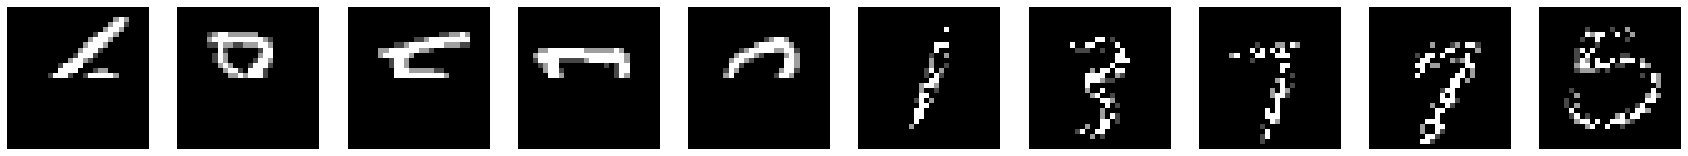

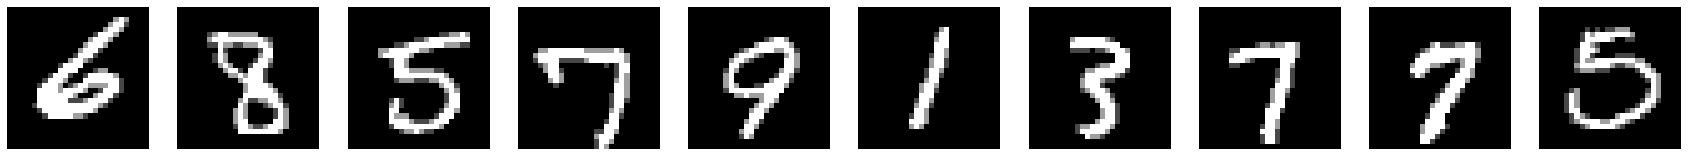

In [ ]:
with strategy.scope():
    training_loop.train()

In [ ]:
training_loop.process_batch()

In [ ]:
model.save("models/dist-anp-3x32x30")